## LSTM aplicado a sensor data series temporales

Prediccion de que una maquina con id x fallara despues de n ciclos de operacion


Autores :   
- Pablo Gonzalez  
- Araceli Sanchez
  
Fecha : 4/10/2025

In [47]:
#Imports
import sys
sys.path.append("../src") 
import models, data, utils, train
import importlib
importlib.reload(models)
importlib.reload(data)
importlib.reload(utils)
importlib.reload(train)

from utils import plot_history
from keras.models import load_model

path de los datasets de pm

In [48]:
TRAIN = "../assets/PM_train.txt"
TEST  = "../assets/PM_test.txt"
TRUTH = "../assets/PM_truth.txt"

In [ ]:
HORIZON = 30     #  period o ciclos de las maquinas
SEQ_LENGTH = 50  # tamanho de la secuencia
ID_COL = "id" #id de la maquina
LABEL_COL = "label_bc" #target falla o no falla 1/0

In [ ]:
from data import load_pm_triplet_to_classification, minmax_fit_transform, make_X_y

# Cargamos y construimos los dataframes adjuntando los labels
df_train, df_test, feature_cols = load_pm_triplet_to_classification(
    TRAIN, TEST, TRUTH, horizon=HORIZON
)

# Escalamos los datos de los sensores con minmax scaler
df_train, df_test, scaler = minmax_fit_transform(df_train, df_test, feature_cols)

# realizamos el split de los datos en X,y para el modelo LSTM
X_train, y_train = make_X_y(df_train, ID_COL, feature_cols, LABEL_COL, SEQ_LENGTH)
X_test,  y_test  = make_X_y(df_test,  ID_COL, feature_cols, LABEL_COL, SEQ_LENGTH)
X_train.shape, y_train.shape, X_test.shape, y_test.shape


((20531, 50, 24), (20531,), (12996, 50, 24), (12996,))

Visualizamos los datos de sensores de las maquinas

In [51]:
df_train.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,ttf,label_bc
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.199608,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.162813,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.171793,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.174889,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.174734,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0


In [52]:
df_test.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,ttf,label_bc
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,142,0
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,141,0
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,140,0
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,139,0
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,138,0


Model: "LSTM_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 50, 100)        │        50,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 50, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,251 (313.48 KB)

 Trainable params: 80,251 (313.48 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 29s 208ms/step - accuracy: 0.9351 - loss: 0.1692 - val_accuracy: 0.9533 - val_loss: 0.1218
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 18s 187ms/step - accuracy: 0.9701 - loss: 0.0742 - val_accuracy: 0.9757 - val_loss: 0.0514
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 18s 188ms/step - accuracy: 0.9710 - loss: 0.0688 - val_accuracy: 0.9883 - val_loss: 0.0378
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 18s 187ms/step - accuracy: 0.9706 - loss: 0.0721 - val_accuracy: 0.9825 - val_loss: 0.0397


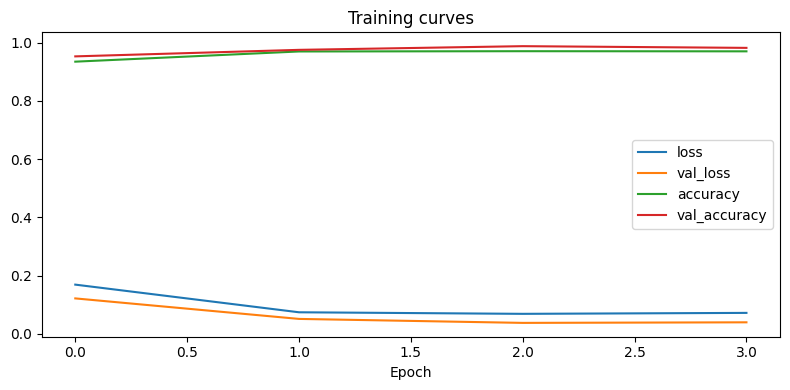

In [53]:
from models import LSTMSimpleClassifier
from train import train, evaluate_on_arrays
nb_features = X_train.shape[2]
timestamp = SEQ_LENGTH  #50

clf = LSTMSimpleClassifier(timestamp=timestamp, nb_features=nb_features, lr=1e-3)
clf.summary()

history = train(
    clf.model,
    X_train, y_train,
    epochs=10,
    batch_size=200,
    validation_split=0.05,
    callbacks=None
)
plot_history(history)

# Métricas (train/test)
train_metrics = evaluate_on_arrays(clf.model, X_train, y_train, batch_size=200)
test_metrics  = evaluate_on_arrays(clf.model, X_test,  y_test,  batch_size=200)



Visualizamos mejor nuestro reporte de clasificacion en train

In [56]:
import pandas as pd
# Convierte el dict en DataFrame y muestra
report_df = pd.DataFrame(train_metrics['report']).transpose()
report_df

,precision,recall,f1-score,support
0,0.985378,0.985830,0.985604,17431.000000
1,0.920116,0.917742,0.918928,3100.000000
accuracy,0.975549,0.975549,0.975549,0.975549
macro avg,0.952747,0.951786,0.952266,20531.000000
weighted avg,0.975524,0.975549,0.975536,20531.000000


Visualizamos mejor nuestro reporte de clasificacion en test

In [59]:
import pandas as pd
# Convierte el dict en DataFrame y muestra
report_df = pd.DataFrame(test_metrics['report']).transpose()
report_df

,precision,recall,f1-score,support
0,0.992533,0.997078,0.994800,12664.000000
1,0.864964,0.713855,0.782178,332.000000
accuracy,0.989843,0.989843,0.989843,0.989843
macro avg,0.928748,0.855467,0.888489,12996.000000
weighted avg,0.989274,0.989843,0.989369,12996.000000


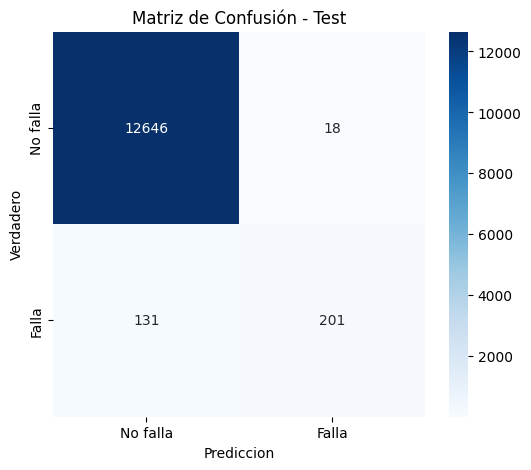

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = test_metrics["confusion_matrix"]

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=["No falla", "Falla"],yticklabels=["No falla", "Falla"], cmap="Blues")
plt.xlabel("Prediccion")
plt.ylabel("Verdadero")
plt.title("Matriz de Confusión - Test")
plt.show()

In [ ]:
import pandas as pd

# Extraemos las metricas principales en un csv
row = {
    'modelo': 'LSTM_PM',
    'accuracy_train': train_metrics['accuracy'],
    'accuracy_test': test_metrics['accuracy'],
    'f1_train': train_metrics['report']['weighted avg']['f1-score'],
    'f1_test': test_metrics['report']['weighted avg']['f1-score'],
    'precision_train': train_metrics['report']['weighted avg']['precision'],
    'precision_test': test_metrics['report']['weighted avg']['precision'],
    'recall_train': train_metrics['report']['weighted avg']['recall'],
    'recall_test': test_metrics['report']['weighted avg']['recall'],
    'epochs': 10
}

csv_path = "../results/lstm/summary_lstm.csv"
try:
    results = pd.read_csv(csv_path)
except FileNotFoundError:
    results = pd.DataFrame(columns=row.keys())

results = pd.concat([results, pd.DataFrame([row])], ignore_index=True)
results.to_csv(csv_path, index=False)

Probamos con una maquina a traves de la funcion prob_failure

In [58]:
from train import predict_classes
from utils import prob_failure
y_pred_test = predict_classes(clf.model, X_test, batch_size=200)
test_metrics["confusion_matrix"]

machine_id = 16  # o el id que quieras
p_fail = prob_failure(clf.model, df_test, machine_id, SEQ_LENGTH, feature_cols, id_col=ID_COL)
print(f"La probabilidad de que la maquina {machine_id} falle en {HORIZON} ciclos es de : {p_fail:.2f}%")


La probabilidad de que la maquina 16 falle en 30 ciclos es de : 0.03%


Conclusion

Como vemos nuestro modelo aprendio bastante bien, con un accuracy de 0.97 en test y 0.99 en train. Generalmente al tener mayor cantidad de datos en que no falla, el accuracy es una metrica que no refleja bien el rendimiento del modelo. Por eso es importante ver otras metricas como precision, recall y f1-score. Vemos que para test tenemos una precision menor en el caso que si falla eso es por el desbalanceo de clases que tenemos en el dataset. Hay mas labels de que no falla que de que si falla.

Pero logramos aplicar nuestro clasificador LSTM a un dataset de series temporales y obtener buenos resultados.